In [2]:
'''
This code shows how to write an ANN to predict the covertype (7 classes),
other remaining features are used for training
'''

import torch

print(torch.__version__)
# 2.11.0.dev20251216+cu130

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# cuda

2.11.0.dev20251216+cu130
cuda


In [7]:
######################
## Data preparation ##
######################

'''
Firstly, install this library:
pip install ucimlrepo
'''

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets
'''Wait a little bit for it to fetch the data'''

print(y.value_counts())
# Cover_Type
# 2             283301
# 1             211840
# 3              35754
# 7              20510
# 6              17367
# 5               9493
# 4               2747
# Name: count, dtype: int64

Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64


In [63]:
'''----- X_scaled -----'''
from sklearn.preprocessing import StandardScaler

X_categ = X.reindex(columns=[col for col in X.columns if col.startswith("Soil_Type") or col.startswith("Wilderness_Area")])
X_quanti = X.drop(columns=X_categ.columns, inplace=False)

X_quanti_scaled = StandardScaler().fit_transform(X_quanti)

import numpy as np
X_scaled = torch.tensor(
    data=np.hstack((X_quanti_scaled, X_categ.to_numpy())),
    device=device,
    dtype=torch.float32
)

print(X_scaled)
# tensor([[-1.2978, -0.9352, -1.4828,  ...,  0.0000,  0.0000,  0.0000],
#         [-1.3192, -0.8905, -1.6164,  ...,  0.0000,  0.0000,  0.0000],
#         [-0.5549, -0.1488, -0.6816,  ...,  0.0000,  0.0000,  0.0000],
#         ...,
#         [-2.0478,  0.0299,  0.3868,  ...,  0.0000,  1.0000,  0.0000],
#         [-2.0550,  0.1282,  0.1197,  ...,  0.0000,  1.0000,  0.0000],
#         [-2.0586,  0.0835, -0.1474,  ...,  0.0000,  1.0000,  0.0000]],
#        device='cuda:0')

print(X_scaled.shape)
# torch.Size([581012, 54])

'''----- y_scaled -----'''
y_scaled = torch.tensor(y.values - 1, dtype=torch.long, device=device).squeeze()  # 1-7 -> 0-6
                                                                                  # MUST SQUEEZE SO THAT CrossEntroypyLoss can work
print(y_scaled)
# tensor([4, 4, 1,  ..., 2, 2, 2], device='cuda:0')

print(y_scaled.shape)
# torch.Size([581012])

tensor([[-1.2978, -0.9352, -1.4828,  ...,  0.0000,  0.0000,  0.0000],
        [-1.3192, -0.8905, -1.6164,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5549, -0.1488, -0.6816,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-2.0478,  0.0299,  0.3868,  ...,  0.0000,  1.0000,  0.0000],
        [-2.0550,  0.1282,  0.1197,  ...,  0.0000,  1.0000,  0.0000],
        [-2.0586,  0.0835, -0.1474,  ...,  0.0000,  1.0000,  0.0000]],
       device='cuda:0')
torch.Size([581012, 54])
tensor([4, 4, 1,  ..., 2, 2, 2], device='cuda:0')
torch.Size([581012])


In [64]:
#######################
## Dataset splitting ##
#######################

train_len = int(0.8 * len(X_scaled)) # MUST be INTEGER
val_len = int(0.1 * len(X_scaled))
test_len = len(X_scaled) - (train_len + val_len)

from torch.utils.data import DataLoader, TensorDataset, random_split

full_dataset = TensorDataset(X_scaled, y_scaled)
train_split, val_split, test_split = random_split(dataset=full_dataset, lengths=[train_len, val_len, test_len])

train_set = DataLoader(train_split, batch_size=2**11, shuffle=True)
val_set = DataLoader(val_split, batch_size=2**11, shuffle=False)
test_set = DataLoader(test_split, batch_size=2**11, shuffle=False)

###############################
## ADSYN to handle imbalance ##
###############################

from imblearn.over_sampling import ADASYN

X_train = X_scaled[train_split.indices].cpu().numpy()  # ✅ Already scaled!
y_train = y_scaled[train_split.indices].cpu().numpy()

adasyn = ADASYN(sampling_strategy='not majority', random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


Class distribution in training set:
  Class 1: 169347 samples, weight: 0.0540
  Class 2: 226794 samples, weight: 0.0403
  Class 3:  28589 samples, weight: 0.3199
  Class 4:   2196 samples, weight: 4.1641
  Class 5:   7583 samples, weight: 1.2059
  Class 6:  13877 samples, weight: 0.6590
  Class 7:  16423 samples, weight: 0.5568


In [65]:
######################
## Model Definition ##
######################
from torch import nn

class ANNmultinomial(nn.Module):
    def __init__(self, input_features=54, num_classes=7, dropout_rate=0.3):
        super().__init__()
        
        self.main = nn.Sequential(
            # Layer 1: 54 inputs -> 128 neurons
            nn.Linear(in_features=input_features, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 2: 128 -> 64 neurons
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 3: 64 -> 32 neurons
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer: 32 -> 7 outputs (NO activation here!)
            nn.Linear(32, num_classes)
            # No Sigmoid! CrossEntropyLoss/FocalLoss expects raw logits
        )
    
    def forward(self, X):
        return self.main(X)

# Initialize model
torch.manual_seed(42)
model = ANNmultinomial(input_features=54, num_classes=7, dropout_rate=0.3)
model.to(device)

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

################
## Focal Loss ##
################

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        """
        Focal Loss for handling class imbalance
        
        Args:
            alpha: Class weights tensor (shape: num_classes)
            gamma: Focusing parameter (default: 2)
                   - gamma=0: equivalent to CrossEntropyLoss
                   - gamma>0: focuses more on hard examples
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # inputs: (batch_size, num_classes) - raw logits
        # targets: (batch_size,) - class indices (0-6)
        
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        return focal_loss.mean()

loss_fn = FocalLoss(alpha=class_weights, gamma=2)

###############
## Optimizer ##
###############

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler for better convergence
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("\n✅ Model, Focal Loss, and Optimizer ready!")
print(f"Device: {device}")
print(f"Learning rate: 0.001")
print(f"Focal Loss gamma: 2")


Total parameters: 18,055

✅ Model, Focal Loss, and Optimizer ready!
Device: cuda
Learning rate: 0.001
Focal Loss gamma: 2


In [66]:
################################
## Training - Validating loop ##
################################

epochs = 100

train_loss_list, val_loss_list = [], []

for epoch in range(1, epochs+1, 1):
    # --- TRAINING ---
    _ = model.train()
    for X_batch, y_batch in train_set:
        y_preds = model(X_batch)
        loss = loss_fn(y_preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() 
    val_loss = 0
    with torch.inference_mode(): 
        for X_val, y_val in val_set: 
            val_preds = model(X_val)
            val_loss += loss_fn(val_preds, y_val).item()
    
    avg_val_loss = val_loss / len(val_set)
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)

    # MUST pass avg_val_loss to scheduler.step() !!!
    scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0:
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss:.3e}")
        print(f"Validation loss: {avg_val_loss:.3e}")
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 10
# Train loss: 9.053e-03
# Validation loss: 7.226e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 20
# Train loss: 9.212e-03
# Validation loss: 6.180e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 30
# Train loss: 7.918e-03
# Validation loss: 5.748e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 40
# Train loss: 5.334e-03
# Validation loss: 5.383e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 50
# Train loss: 8.071e-03
# Validation loss: 5.085e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 60
# Train loss: 7.281e-03
# Validation loss: 4.359e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 70
# Train loss: 4.481e-03
# Validation loss: 4.100e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 80
# Train loss: 5.757e-03
# Validation loss: 4.134e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 90
# Train loss: 3.328e-03
# Validation loss: 3.948e-03
# ++++++++++++++++++++++++++++++++++++++++++++++++++
# Epoch: 100
# Train loss: 6.079e-03
# Validation loss: 3.852e-03

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 9.053e-03
Validation loss: 7.226e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 9.212e-03
Validation loss: 6.180e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30
Train loss: 7.918e-03
Validation loss: 5.748e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 40
Train loss: 5.334e-03
Validation loss: 5.383e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 50
Train loss: 8.071e-03
Validation loss: 5.085e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 60
Train loss: 7.281e-03
Validation loss: 4.359e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 70
Train loss: 4.481e-03
Validation loss: 4.100e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 80
Train loss: 5.757e-03
Validation loss: 4.134e-03
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 90
Train loss: 3.328e-03
Validation loss: 3.948e-03
++++++++++

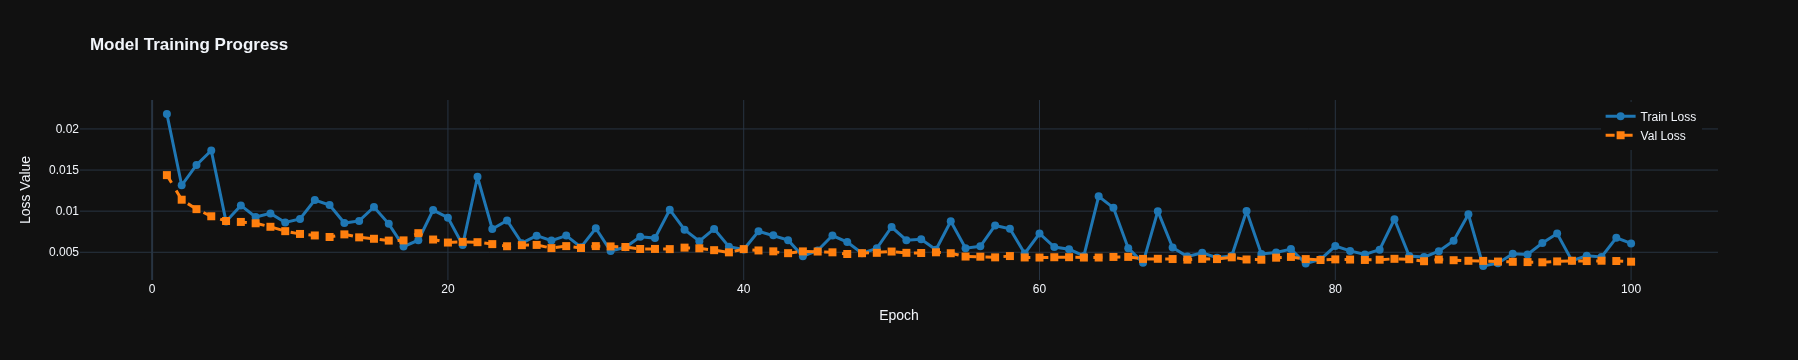

In [67]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves():
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves()

In [69]:
#############
## Testing ##
#############

test_loss = 0
test_preds_list = []
test_true_list = []

model.eval()

with torch.inference_mode():
    for X_test, y_test in test_set:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_test = y_test.squeeze()  # Remove extra dimension
        
        test_preds = model(X_test)  # Raw logits (batch_size, 7)
        
        # Accumulate loss
        test_loss += loss_fn(test_preds, y_test).item()
        
        # Get predicted class (argmax of logits)
        _, predicted_classes = torch.max(test_preds, 1)
        
        # Collect predictions and true labels
        test_preds_list.append(predicted_classes.cpu())
        test_true_list.append(y_test.cpu())

# Calculate average test loss
avg_test_loss = test_loss / len(test_set)
print(f"Average Test Loss: {avg_test_loss:.4f}\n")

# Concatenate all batches
test_preds_class = torch.cat(test_preds_list, dim=0).numpy()  # Predicted classes (0-6)
test_true = torch.cat(test_true_list, dim=0).numpy()  # True classes (0-6)

# Calculate metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

accuracy = accuracy_score(test_true, test_preds_class)
print(f'Accuracy on test set: {accuracy:.4f}\n')

# Confusion Matrix
labels = [f'Class {i+1}' for i in range(7)]  # Class 1-7 for display
cm = confusion_matrix(test_true, test_preds_class)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print(f'Confusion matrix:\n{cm_df}\n')

# Classification Report
print(f'Classification report:\n{classification_report(test_true, test_preds_class, target_names=labels, digits=4)}\n')

# Per-class accuracy (useful for imbalanced datasets)
print("Per-class accuracy:")
for i in range(7):
    class_mask = (test_true == i)
    if class_mask.sum() > 0:
        class_acc = (test_preds_class[class_mask] == i).sum() / class_mask.sum()
        print(f"  Class {i+1}: {class_acc:.4f} ({class_mask.sum()} samples)")
    else:
        print(f"  Class {i+1}: No samples in test set")

# Check minority class performance (Class 4 and 5)
print("\n⚠️ Minority class performance:")
for i in [3, 4]:  # Class 4 and 5 (indices 3 and 4)
    class_mask = (test_true == i)
    if class_mask.sum() > 0:
        recall = (test_preds_class[class_mask] == i).sum() / class_mask.sum()
        precision = (test_preds_class == i).sum()
        if precision > 0:
            precision = (test_preds_class[class_mask] == i).sum() / (test_preds_class == i).sum()
        else:
            precision = 0
        print(f"  Class {i+1}: Recall={recall:.4f}, Precision={precision:.4f}")

Average Test Loss: 0.0047

Accuracy on test set: 0.2988

Confusion matrix:
         Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7
Class 1     9316      277        1        0     2027      124     9478
Class 2    11215     1687      371        6    10558     1652     2854
Class 3        0        0     1463      243      151     1713        0
Class 4        0        0        0      264        0        3        0
Class 5        0        0        0        0      967        3        0
Class 6        0        0        8       50       10     1637        0
Class 7        0        0        0        0        0        0     2024

Classification report:
              precision    recall  f1-score   support

     Class 1     0.4538    0.4390    0.4462     21223
     Class 2     0.8590    0.0595    0.1113     28343
     Class 3     0.7938    0.4098    0.5406      3570
     Class 4     0.4689    0.9888    0.6361       267
     Class 5     0.0705    0.9969    0.1317       970
     Cla